**Problem**: Given a phishing url, classify the domain as compromised (owned) or malicious (hacked).

**Objective**: Given labeled data, analyze the best model and features.

In [1]:
import sklearn
print(sklearn.__version__)

0.19.1


# Setup

In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression

#from sklearn.impute import SimpleImputer

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#import xgboost as xgb

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# orange
from Orange.classification.rules import CN2Learner
from Orange.evaluation import compute_CD, graph_ranks

# scipy
import scipy
from scipy.stats import friedmanchisquare
from scipy.stats import rankdata

from pprint import pprint

import pickle

import numpy as np
from numpy import nan

import random

/home/sophie/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Data

In [3]:
# balanced train and test sets
def balance_data(X, y):
    X_bal = []
    y_bal = []
    X_rest = []
    y_rest = []
    min1 = len([tar for tar in y if tar==1])
    min2 = len([tar for tar in y if tar==-1])
    mini = min1
    if min2 < min1:
        mini = min2

    cnt_1 = 0
    cnt_0 = 0
    print(mini)
    for i, tar in enumerate(y):
        if tar == 1 and cnt_1<mini:
            cnt_1+=1
            X_bal.append(X[i])
            y_bal.append(y[i])
        elif tar == -1 and cnt_0<mini:
            cnt_0+=1
            X_bal.append(X[i])
            y_bal.append(y[i])
        else:
            X_rest.append(X[i])
            y_rest.append(y[i])

    print("# X_bal:", len(X_bal))
    print("# y_bal:", len(y_bal))
    print("% compromised: ", len([tar for tar in y_bal if tar==1])/len(y_bal))
    print("% malicious: ", len([tar for tar in y_bal if tar==-1])/len(y_bal))
    
    print("# X_rest:", len(X_rest))
    print("# y_rest:", len(y_rest))
    print("% compromised: ", len([tar for tar in y_rest if tar==1])/len(y_rest))
    print("% malicious: ", len([tar for tar in y_rest if tar==-1])/len(y_rest))
    
    return [X_bal, y_bal, X_rest, y_rest]

### Train/Test

In [4]:
with open("data/data_cluster_5744", "r", encoding='utf-8') as f:
    data_train = eval(f.read())
    
random.Random(4).shuffle(data_train)

In [5]:
# # remove specific features
# for d in data_train:
#     feat_temp = d['feat']
#     feat_labels = d['feat_labels']
# #     d['feat'] = feat_temp[0:5] + feat_temp[6:16] + feat_temp[17:19]
# #     d['feat_labels'] = feat_labels[0:5] + feat_labels[6:16] + feat_labels[17:19]
#     d['feat'] = [feat_temp[4]] + feat_temp[6:16] + feat_temp[17:19]
#     d['feat_labels'] = [feat_labels[4]] + feat_labels[6:16] + feat_labels[17:19]

In [6]:
Xtrain = np.array([d['feat'] for d in data_train])
ytrain = np.array([d['target'] for d in data_train])
feat_labels = data_train[0]['feat_labels']
print(Xtrain.shape)
print(ytrain.shape)
print(feat_labels)
pprint(data_train[:5])
pprint(Xtrain[:5])
pprint(ytrain[:5])
print("# compromised: ", len([tar for tar in ytrain if tar==1]))
print("# malicious: ", len([tar for tar in ytrain if tar==-1]))
print("% compromised: ", len([tar for tar in ytrain if tar==1])/len(ytrain))
print("% malicious: ", len([tar for tar in ytrain if tar==-1])/len(ytrain))

(5744, 19)
(5744,)
['archived', 'years_active', 'years_inactive', 'num_captures', 'freenom_tld', 'prev_mal_tld', 'wildcard_subdomain', 'reachable', 'redirected', 'blocked', 'alexa_rank', 'ratio_longest_word', 'contain_digit', 'contain_dash', 'name_len', 'brandname_partialratio', 'prev_mal_domain_ed', 'sub_levels', 'num_sub']
[{'dataset': 'unlabeled-apwg',
  'feat': [1,
           8,
           0,
           56.0,
           0,
           0,
           1,
           1,
           0,
           0,
           nan,
           0.3333333333333333,
           0,
           0,
           6,
           80,
           0.16666666666666666,
           0,
           1],
  'feat_labels': ['archived',
                  'years_active',
                  'years_inactive',
                  'num_captures',
                  'freenom_tld',
                  'prev_mal_tld',
                  'wildcard_subdomain',
                  'reachable',
                  'redirected',
                  'blocked',
 

In [7]:
# balance
Xtrain, ytrain, Xtest, ytest = balance_data(Xtrain, ytrain)

2042
# X_bal: 4084
# y_bal: 4084
% compromised:  0.5
% malicious:  0.5
# X_rest: 1660
# y_rest: 1660
% compromised:  1.0
% malicious:  0.0


### Predict

In [8]:
with open("/home/sophie/SSRG/domainclassification/results/dataset/domain_target_55383", "r", encoding='utf-8') as f:
    data_predict = eval(f.read())
    
random.Random(4).shuffle(data_predict)
    
datasets = set([d['dataset'] for d in data_predict])
pprint(datasets)

{'comp-deltaphish',
 'comp-phishlabs',
 'mal-apwg',
 'mal-future-apwg',
 'mal-phishlabs',
 'unlabeled-apwg'}


In [9]:
# # remove specific features
# for d in data_predict:
#     feat_temp = d['feat']
#     feat_labels = d['feat_labels']
# #     d['feat'] = feat_temp[0:5] + feat_temp[6:16] + feat_temp[17:19]
# #     d['feat_labels'] = feat_labels[0:5] + feat_labels[6:16] + feat_labels[17:19]
#     d['feat'] = [feat_temp[4]] + feat_temp[6:16] + feat_temp[17:19]
#     d['feat_labels'] = [feat_labels[4]] + feat_labels[6:16] + feat_labels[17:19]

#### Length of each dataset

In [10]:
for dn in datasets:
    x = [d for d in data_predict if d['dataset'] == dn]
    print("%s: %s" % (dn, str(len(x))))

unlabeled-apwg: 50412
mal-phishlabs: 2804
mal-future-apwg: 314
mal-apwg: 495
comp-phishlabs: 669
comp-deltaphish: 689


#### Cluster training

In [11]:
#data used for cluster training
dataset_val = {"comp-phishlabs", "mal-apwg"}
#dataset_val = {"comp-deltaphish", "mal-phishlabs"}
Xval = np.array([d['feat'] for d in data_predict if d['dataset'] in dataset_val])
yval = np.array([d['target'] for d in data_predict if d['dataset'] in dataset_val])
feat_labels = data_predict[0]['feat_labels']
print(Xval.shape)
print(yval.shape)
print(feat_labels)
pprint(Xval[:5])
pprint(yval[:5])
print("# compromised: ", len([tar for tar in yval if tar==1]))
print("# malicious: ", len([tar for tar in yval if tar==-1]))
print("% compromised: ", len([tar for tar in yval if tar==1])/len(yval))
print("% malicious: ", len([tar for tar in yval if tar==-1])/len(yval))

(1164, 19)
(1164,)
['archived', 'years_active', 'years_inactive', 'num_captures', 'freenom_tld', 'prev_mal_tld', 'wildcard_subdomain', 'reachable', 'redirected', 'blocked', 'alexa_rank', 'ratio_longest_word', 'contain_digit', 'contain_dash', 'name_len', 'brandname_partialratio', 'prev_mal_domain_ed', 'sub_levels', 'num_sub']
array([[1.00000000e+00, 1.60000000e+01, 1.00000000e+00, 8.44000000e+02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.30597000e+05, 3.15789474e-01,
        0.00000000e+00, 0.00000000e+00, 1.50000000e+01, 6.70000000e+01,
        6.66666667e-02, 1.00000000e+00, 1.00000000e+00],
       [0.00000000e+00,            nan,            nan,            nan,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 0.00000000e+00,            nan, 3.18181818e-01,
        0.00000000e+00, 0.00000000e+00, 1.80000000e+01, 1.00000000e+02,
        5.55555556e-02, 0.00000000e+00, 

In [12]:
# balance
Xvalb, yvalb, Xvaltestb, yvaltestb = balance_data(Xval, yval)

495
# X_bal: 990
# y_bal: 990
% compromised:  0.5
% malicious:  0.5
# X_rest: 174
# y_rest: 174
% compromised:  1.0
% malicious:  0.0


# Normalize and imputer

In [13]:
# imp = Imputer(missing_values=np.nan, strategy='mean')
# imp.fit(Xtrain)
# Xtrain = imp.transform(Xtrain)
# print(Xtrain[:2])

Xtrain = np.where(np.isnan(Xtrain), -1, Xtrain)

In [14]:
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)

print(Xtrain[:2])

[[ 0.92722435  0.81833029  0.0065093  -0.02239467 -0.01564985 -1.
   0.95497907  0.56075952  0.28806702  0.52184356 -0.12365408 -0.1166644
  -0.21031931 -0.28610191 -1.27603584  0.45512287  1.78179319 -0.42247349
  -0.16238174]
 [-1.07848764 -0.68529639 -0.97808278 -0.0425758  -0.01564985  1.
  -1.04714337  0.56075952  2.12342695  0.52184356 -0.12365408 -0.60571251
  -0.21031931 -0.28610191  1.28848052 -0.6150478  -1.05640703 -0.42247349
   0.49617539]]


In [15]:
#Xvalb = imp.transform(Xvalb)
Xvalb = np.where(np.isnan(Xvalb), -1, Xvalb)
Xvalb = scaler.transform(Xvalb)
print(Xvalb[:2])

[[ 0.92722435  2.15488733  0.99110138  0.25660064 -0.01564985 -1.
  -1.04714337  0.56075952  0.28806702  0.52184356  9.5687551  -0.29684002
  -0.21031931 -0.28610191  0.82220482 -0.6150478  -0.84999247  1.53818755
  -0.16238174]
 [-1.07848764 -0.68529639 -0.97808278 -0.0425758  -0.01564985  1.
  -1.04714337  0.56075952  2.12342695  0.52184356 -0.12365408 -0.27227061
  -0.21031931 -0.28610191  1.52161837  2.10153929 -1.1424131  -0.42247349
   0.49617539]]


# Feature calibration

In [16]:
def sortAscendingFeature(cX, cy):
    idx_cX = np.argsort(cX)
    cX = np.array(cX)[idx_cX]
    cy = np.array(cy)[idx_cX]
    return cX, idx_cX, cy

In [17]:
# test
cX = [3,4,5,1,2]
cy = [1,1,1,0,0]
x = sortAscendingFeature(cX,cy)
print(x)
cX, idx_cX, cy = x
idx_cX_sort = np.argsort(idx_cX)
cX = np.array(cX)[idx_cX_sort]
print(idx_cX_sort)
print(cX)

(array([1, 2, 3, 4, 5]), array([3, 4, 0, 1, 2]), array([0, 0, 1, 1, 1]))
[2 3 4 0 1]
[3 4 5 1 2]


In [18]:
def calibratedFeature(cX, cy, iso=None):
    cX, idx_cX, cy = sortAscendingFeature(cX, cy)
    #print(cX[:-20])
    
    if iso is None:
        #iso = IsotonicRegression()
        iso = IsotonicRegression(out_of_bounds='clip')
        iso.fit(cX, cy)
        
    cX = iso.transform(cX)
    #print(cX[:-20])
    
    # sort back to original indexes
    idx_cX_sort = np.argsort(idx_cX)
    cX = np.array(cX)[idx_cX_sort]
    return cX, iso

In [19]:
# calibrated features
cfeatures = {'years_active', 'years_inactive', 'num_captures', 'alexa_rank', 'sub_levels', 'num_sub', 'brandname_partialratio', 'name_len'}

iso_functions = []
Xtrain_new = np.copy(Xtrain)
for i, feat in enumerate(feat_labels):
    if feat in cfeatures:

        cX, cy = Xtrain_new[:,i], ytrain
        cX, iso = calibratedFeature(cX, cy)
        
        Xtrain_new[:, i] = cX
        iso_functions.append(iso)
        
print(len(iso_functions))

8


#### Visualize calibrated features

In [22]:
def plotFractionalGraph(x, y=None, xlabel="", xmin=0, xmax=4000):
    #print(y)
    #print(x)

    ax = plt.subplot()
    ax.plot(x)

    plt.ylabel("Years active")
    plt.xlabel("Number of domains")
    #plt.ylabel("Fraction of Unique URLs")
    #plt.axis([xmin, xmax, 0, 1])
    plt.grid(True, linestyle='dotted')

    plt.show()

years_active


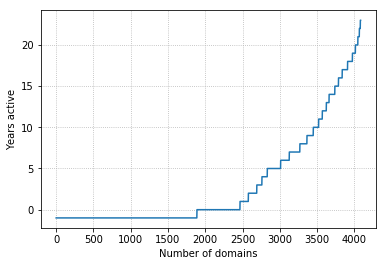

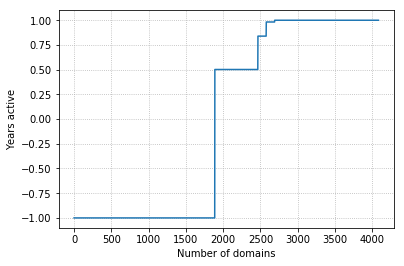

years_inactive


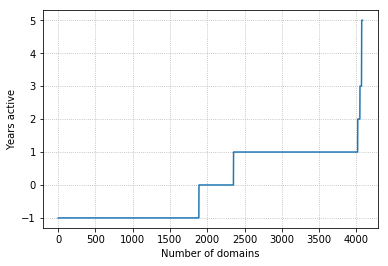

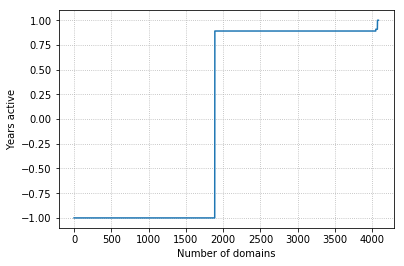

num_captures


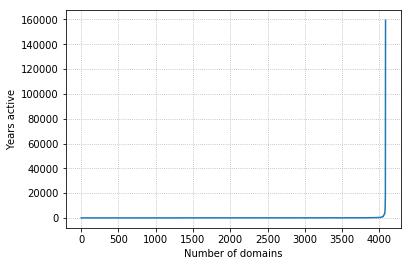

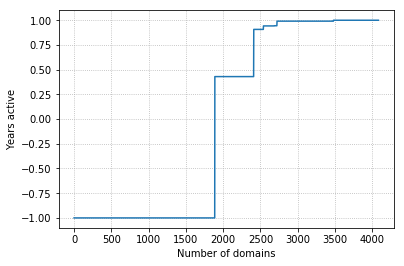

alexa_rank


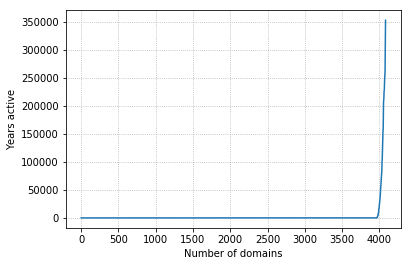

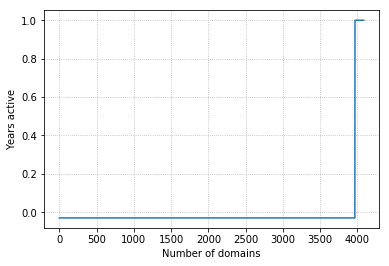

name_len


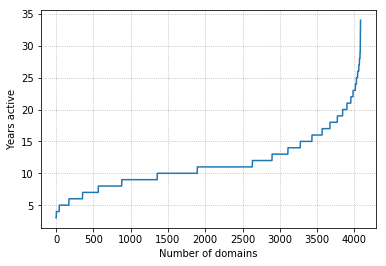

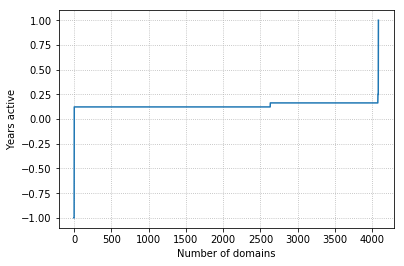

brandname_partialratio


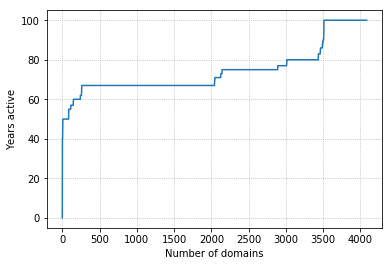

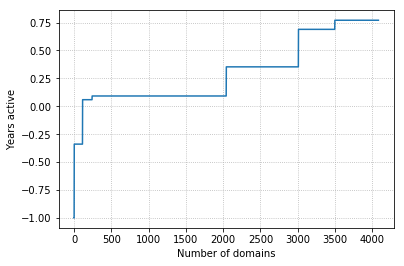

sub_levels


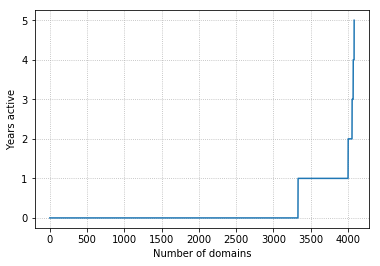

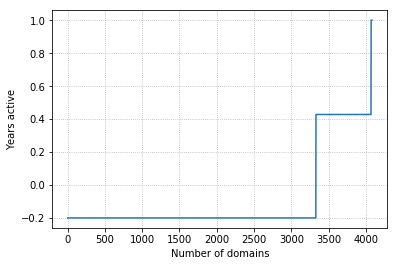

num_sub


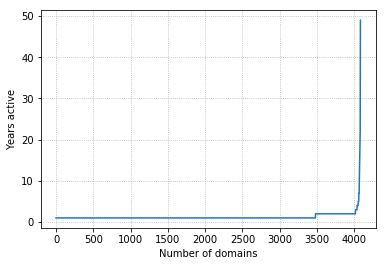

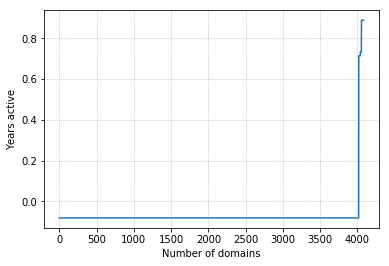

In [23]:
for i, feat in enumerate(feat_labels):
    if feat in cfeatures:
        print(feat)
        # get feat before and after
        feat_before = Xtrain[:,i]
        feat_after = Xtrain_new[:,i]
        
        # sort feats
        feat_before = np.sort(np.array(feat_before))
        feat_after = np.sort(np.array(feat_after))
        
        plotFractionalGraph(feat_before)
        plotFractionalGraph(feat_after)
        #plt.plot(feat_before)

In [22]:
Xtrain = Xtrain_new

#### Apply calibrated features

In [23]:
def applyIsoFunction(X, y, iso_functions):
    cnt = 0
    for i, feat in enumerate(feat_labels):
        if feat in cfeatures:
            
            # select specific feature
            cX = X[:,i]
            
            # get transformed feature with specific iso function
            cX, _ = calibratedFeature(cX, y, iso_functions[cnt])
            cnt+=1
            
            # update calibrated feature
            X[:, i] = cX
    
    return X

In [24]:
Xvalb_new = np.copy(Xvalb)
Xvalb_new = applyIsoFunction(Xvalb_new, yvalb, iso_functions)

years_active


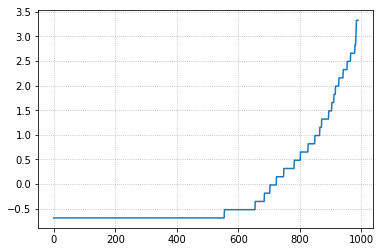

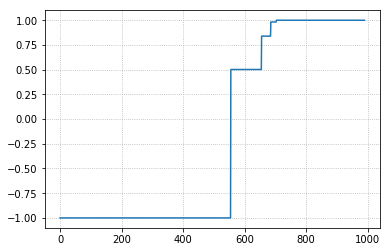

years_inactive


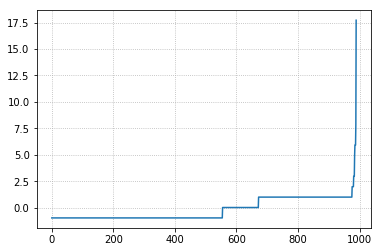

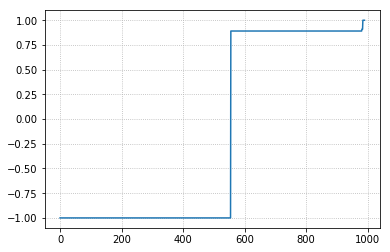

num_captures


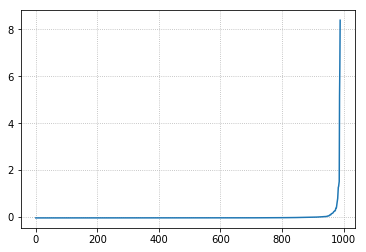

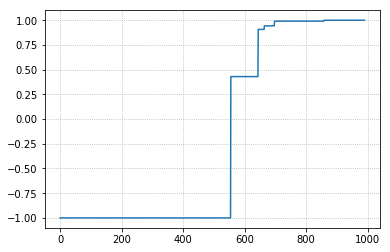

alexa_rank


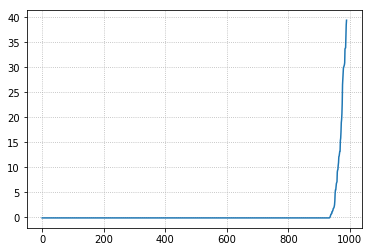

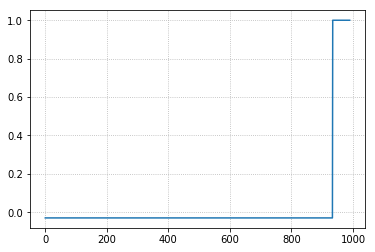

name_len


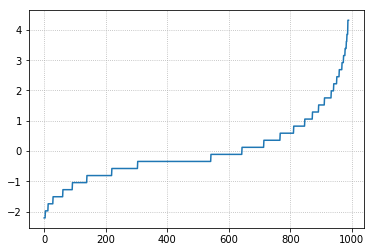

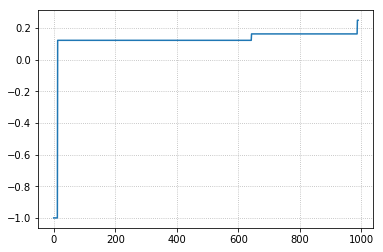

brandname_partialratio


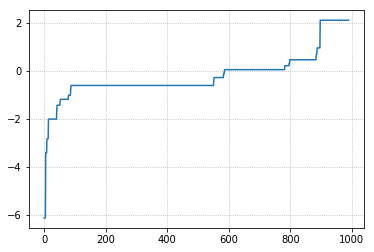

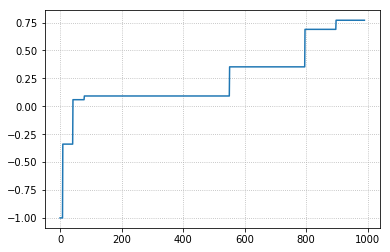

sub_levels


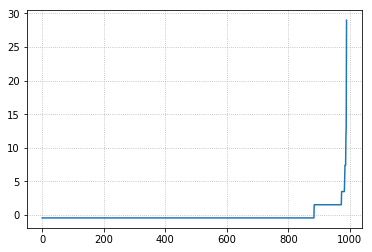

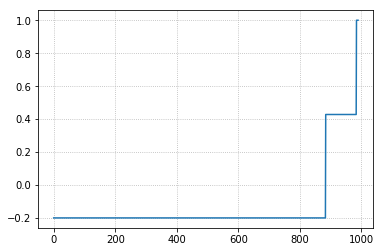

num_sub


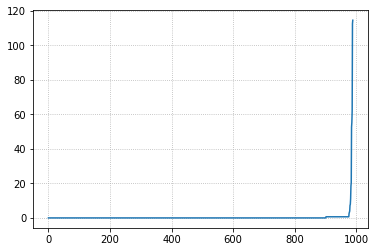

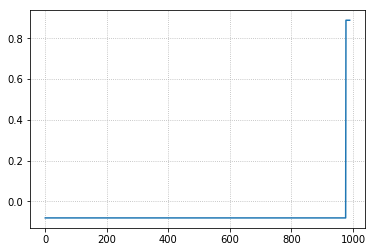

In [25]:
for i, feat in enumerate(feat_labels):
    if feat in cfeatures:
        print(feat)
        # get feat before and after
        feat_before = Xvalb[:,i]
        feat_after = Xvalb_new[:,i]
        
        # sort feats
        feat_before = np.sort(np.array(feat_before))
        feat_after = np.sort(np.array(feat_after))
        
        plotFractionalGraph(feat_before)
        plotFractionalGraph(feat_after)
        #plt.plot(feat_before)

In [26]:
Xvalb = Xvalb_new

# Visualize data with t-SNE

Takes a high dimensional dataset and reduces to a low dimensional graph that retains a lot of the original information.

What t-SNE does is find a way to project data into a low dimensional space so that the clustering in the high dimensional space is preserved.

O(n^2) time and memory. 

In [94]:
def plottsne(data, ax, title=None):
    X_embedded = data[0]
    y = data[1]
    sc = ax.scatter(X_embedded[:, 0], X_embedded[:, 1],
                c=y, marker='o', alpha=.3)
    #plt.colorbar(sc)
    if title:
        ax.set_title(title)
    return sc

In [95]:
def plotsidebyside(tr, te, title1=None, title2=None):
    # display images
    fig, ax = plt.subplots(1,2)
    #fig.set_size_inches(18.5, 10.5)
    fig.set_size_inches(15, 7)
    
    if tr:
        sc_tr = plottsne(tr, ax[0], title1)
    if te:
        sc_te = plottsne(te, ax[1], title2)
    
    #plt.figure(figsize=(15, 15))
    print("blue malicious (owned), yellow compromised (hacked)")

In [96]:
Xtrain_embedded = TSNE(n_components=2, perplexity=40, verbose=0).fit_transform(Xtrain)

blue malicious (owned), yellow compromised (hacked)


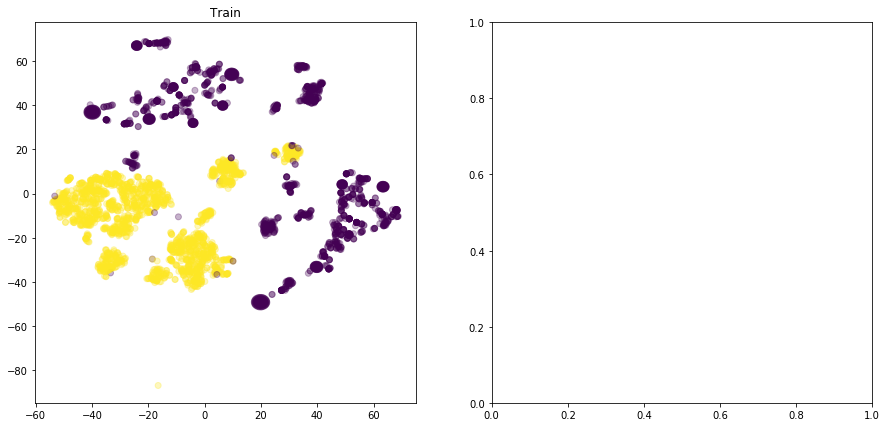

In [97]:
plotsidebyside([Xtrain_embedded, ytrain], None, title1="Train", title2="Test")

In [98]:
Xvalb_embedded = TSNE(n_components=2, perplexity=40, verbose=0).fit_transform(Xvalb)

blue malicious (owned), yellow compromised (hacked)


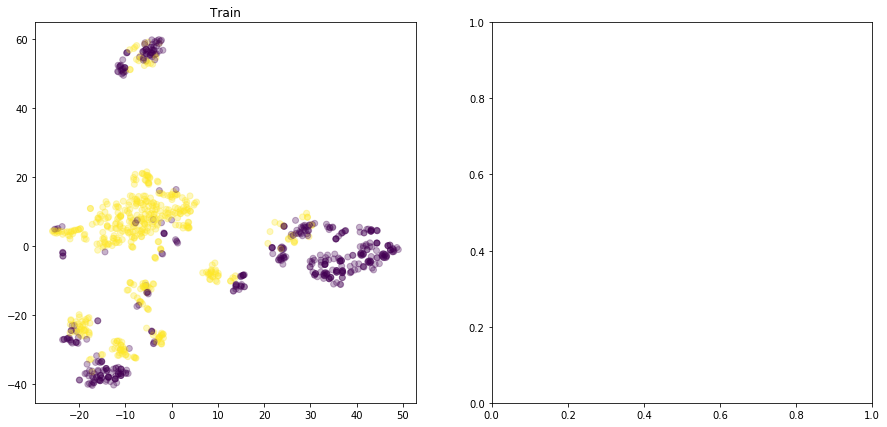

In [99]:
# deltaphish phishlabs
plotsidebyside([Xvalb_embedded, yvalb], None, title1="Train", title2="Test")

# Models

#### Default

In [27]:
names = [
         "KNeighbors", 
         #"SVM", 
         "NeuralNetwork",
         "DecisionTree", 
         #"CN2Learner",
         "RandomForest",
         "GaussianNB"
         "Dummy",
        ]

classifiers = [
    KNeighborsClassifier(),
    #SVC(random_state=42, probability=True),
    MLPClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    #CN2Learner(),
    #RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1, random_state=42),
    RandomForestClassifier(random_state=42),
    GaussianNB(),
    DummyClassifier(random_state=42),
]

#### Tunned with calibration

In [57]:
names = [
         "KNeighbors", 
         #"SVM", 
         "NeuralNetwork",
         "DecisionTree", 
         "RandomForest",
         "GaussianNB",
         "Dummy",
        ]

#[200, 'identity', 'sgd', 500, 0.001, 0.9911851126346719, 0.8626262626262626]
classifiers = [
    KNeighborsClassifier(n_neighbors=14, weights='distance', p=2),
    #SVC(kernel="rbf", random_state=42, probability=True),
    MLPClassifier(hidden_layer_sizes=200, activation='identity', solver='sgd', batch_size=100, learning_rate_init=0.0001, random_state=42),
    DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='auto', random_state=42),
    #DecisionTreeClassifier(random_state=42),
    #RandomForestClassifier(n_estimators=100, max_depth=5, max_features=1, random_state=42),
    RandomForestClassifier(n_estimators=100, max_depth=1, max_features='auto', random_state=42),
    #RandomForestClassifier(n_estimators=50, max_depth=3, max_features=1, random_state=42),
    GaussianNB(),
    DummyClassifier(random_state=42),
]

#### Tunned no calibration

In [28]:
names = [
         "KNeighbors", 
         #"SVM", 
         "NeuralNetwork",
         "DecisionTree", 
         "RandomForest",
         "GaussianNB",
         "Dummy",
        ]

#[200, 'identity', 'sgd', 500, 0.001, 0.9911851126346719, 0.8626262626262626]
classifiers = [
    KNeighborsClassifier(n_neighbors=13, weights='distance', p=2),
    #SVC(kernel="rbf", random_state=42, probability=True),
    MLPClassifier(hidden_layer_sizes=200, activation='identity', solver='sgd', batch_size=200, learning_rate_init=0.001, random_state=42),
    DecisionTreeClassifier(criterion='gini', max_depth=None, max_features='auto', random_state=42),
    #DecisionTreeClassifier(random_state=42),
    #RandomForestClassifier(n_estimators=100, max_depth=5, max_features=1, random_state=42),
    RandomForestClassifier(n_estimators=100, max_depth=1, max_features='auto', random_state=42),
    #RandomForestClassifier(n_estimators=50, max_depth=3, max_features=1, random_state=42),
    GaussianNB(),
    DummyClassifier(random_state=42),
]

# Model tuning

In [29]:
def trainvalModel(clf):
    #clf = CalibratedClassifierCV(clf, cv=10, method='isotonic')
    clf.fit(Xtrain, ytrain)

    ytrain_pred = clf.predict(Xtrain)
    acc_train = accuracy_score(ytrain, ytrain_pred)

    yval_pred = clf.predict(Xvalb)
    acc_val = accuracy_score(yvalb, yval_pred)
    
    return acc_train, acc_val

In [30]:
def tuneModel(name, hyperparams):
    res = []
    if name == "KNeighbors":
        for n_n in hyperparams['n_neighbors']:
            for w in hyperparams['weights']:
                for pnum in hyperparams['p']:
                    clf = KNeighborsClassifier(n_neighbors=n_n, weights=w, p=pnum)
                    
                    acc_train, acc_val = trainvalModel(clf)
                    entry = [n_n, w, pnum, acc_train, acc_val]
                    
                    #print(entry)
                    res.append(entry)
                    
    elif name == "SVM":
        #for g in hyperparams['gamma']:
        for k in hyperparams['kernel']:
            for sh in hyperparams['shrinking']:
                #for d in hyperparams['degree']:
                clf = SVC(kernel=k, shrinking=sh, random_state=42)

                acc_train, acc_val = trainvalModel(clf)
                entry = [k, sh, acc_train, acc_val]

                #print(entry)
                res.append(entry)

    elif name == "DecisionTree":
        for c in hyperparams['criterion']:
            #for sp in hyperparams['splitter']:
            for md in hyperparams['max_depth']:
                for ms in hyperparams['min_samples_split']:
                    #for ml in hyperparams['min_samples_leaf']:
                    for mf in hyperparams['max_features']:
                        clf = DecisionTreeClassifier(criterion=c, max_depth=md, min_samples_split=ms, max_features=mf, random_state=42)

                        acc_train, acc_val = trainvalModel(clf)
                        entry = [c, md, ms, mf, acc_train, acc_val]

                        #print(entry)
                        res.append(entry)

    elif name == "RandomForest":
        #for c in hyperparams['criterion']:
        for ne in hyperparams['n_estimators']:
            for md in hyperparams['max_depth']:
                #for ms in hyperparams['min_samples_split']:
                    #for ml in hyperparams['min_samples_leaf']:
                for mf in hyperparams['max_features']:
                    clf = RandomForestClassifier(n_estimators=ne, max_depth=md, max_features=mf, random_state=42)

                    acc_train, acc_val = trainvalModel(clf)
                    entry = [ne, md, mf, acc_train, acc_val]

                    #print(entry)
                    res.append(entry)

    elif name == "NeuralNetwork":
        for hl in hyperparams['hidden_layer_sizes']:
            for ac in hyperparams['activation']:
                for sol in hyperparams['solver']:
                    for bs in hyperparams['batch_size']:
                        for lr in hyperparams['learning_rate_init']:
                            clf = MLPClassifier(hidden_layer_sizes=hl, activation=ac, solver=sol, batch_size=bs, learning_rate_init=lr, random_state=42)

                            acc_train, acc_val = trainvalModel(clf)
                            entry = [hl, ac, sol, bs, lr, acc_train, acc_val]

                            #print(entry)
                            res.append(entry)
                            
    elif name == "NaiveBayes":
        clf = GaussianNB()
        acc_train, acc_val = trainvalModel(clf)
        entry = [acc_train, acc_val]

        #print(entry)
        res.append(entry)
        
    elif name == "Dummy":
        clf = DummyClassifier()
        acc_train, acc_val = trainvalModel(clf)
        entry = [acc_train, acc_val]

        #print(entry)
        res.append(entry)
    
    return res

#### KNeighbors

In [31]:
hyperparams = dict()
hyperparams['n_neighbors'] = list(range(5,15))
hyperparams['weights'] = ['uniform', 'distance']
hyperparams['p'] = [1, 2]
name = "KNeighbors"
res = tuneModel(name, hyperparams)

In [32]:
res_sorted = sorted(res, key=lambda x: x[-1], reverse=True)

In [33]:
pprint(res_sorted[:5])

[[14, 'distance', 2, 1.0, 0.8252525252525252],
 [13, 'uniform', 2, 0.9970617042115573, 0.8232323232323232],
 [13, 'distance', 2, 1.0, 0.8232323232323232],
 [14, 'uniform', 2, 0.9970617042115573, 0.8232323232323232],
 [7, 'uniform', 2, 0.9985308521057786, 0.8222222222222222]]


#### Neural Network

In [52]:
hyperparams = dict()
hyperparams['hidden_layer_sizes'] = [50, 100, 200]
hyperparams['activation'] = ['identity', 'logistic', 'tanh', 'relu']
hyperparams['solver'] = ['lbfgs', 'sgd', 'adam']
hyperparams['batch_size'] = [100, 200, 500]
hyperparams['learning_rate_init'] = [0.01, 0.001, 0.0001]
#hyperparams['degree'] = list(range(1,10))
name = "NeuralNetwork"
res = tuneModel(name, hyperparams)

/home/sophie/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [53]:
res_sorted = sorted(res, key=lambda x: x[-1], reverse=True)

In [54]:
pprint(res_sorted[:20])

[[200, 'identity', 'sgd', 100, 0.0001, 0.9904505386875612, 0.8575757575757575],
 [50, 'identity', 'sgd', 100, 0.0001, 0.9906953966699314, 0.8565656565656565],
 [200, 'identity', 'sgd', 500, 0.001, 0.9911851126346719, 0.8565656565656565],
 [200, 'tanh', 'sgd', 100, 0.0001, 0.990205680705191, 0.8555555555555555],
 [50, 'identity', 'sgd', 500, 0.001, 0.9911851126346719, 0.8545454545454545],
 [200, 'identity', 'sgd', 200, 0.0001, 0.9889813907933399, 0.8535353535353535],
 [200, 'tanh', 'sgd', 500, 0.001, 0.9911851126346719, 0.8535353535353535],
 [50, 'identity', 'sgd', 200, 0.0001, 0.9889813907933399, 0.8525252525252526],
 [50, 'tanh', 'sgd', 100, 0.0001, 0.990205680705191, 0.8525252525252526],
 [200, 'tanh', 'sgd', 200, 0.0001, 0.9877571008814887, 0.8525252525252526],
 [50, 'logistic', 'sgd', 100, 0.0001, 0.9870225269343781, 0.8515151515151516],
 [50, 'tanh', 'sgd', 500, 0.0001, 0.9853085210577864, 0.8515151515151516],
 [200, 'identity', 'sgd', 500, 0.0001, 0.9872673849167483, 0.8515151515

#### SVM

In [302]:
hyperparams = dict()
hyperparams['kernel'] = ['linear', 'rbf', 'sigmoid']
hyperparams['shrinking'] = [True, False]
#hyperparams['degree'] = list(range(1,10))
name = "SVM"
res = tuneModel(name, hyperparams)

In [303]:
res_sorted = sorted(res, key=lambda x: x[-1], reverse=True)

In [304]:
pprint(res_sorted[:20])

[['linear', True, 1.0, 0.8363636363636363],
 ['linear', False, 1.0, 0.8363636363636363],
 ['rbf', True, 1.0, 0.793939393939394],
 ['rbf', False, 1.0, 0.793939393939394],
 ['sigmoid', True, 0.9796264855687606, 0.7565656565656566],
 ['sigmoid', False, 0.9796264855687606, 0.7565656565656566]]


#### Decision Tree

In [34]:
hyperparams = dict()
hyperparams['criterion'] = ['gini', 'entropy']
#hyperparams['splitter'] = ['best', 'random']
hyperparams['max_depth'] = [None] + list(range(1,10))
hyperparams['min_samples_split'] = list(range(2,5))
#hyperparams['min_samples_leaf'] = list(range(1,10))
hyperparams['max_features'] = [None, "auto", "sqrt", "log2"] + list(range(1,10))
name = "DecisionTree"
res = tuneModel(name, hyperparams)

In [35]:
res_sorted = sorted(res, key=lambda x: x[-1], reverse=True)

In [36]:
pprint(res_sorted[:1000])

[['gini', None, 2, 'auto', 1.0, 0.8626262626262626],
 ['gini', None, 2, 'sqrt', 1.0, 0.8626262626262626],
 ['gini', None, 2, 'log2', 1.0, 0.8626262626262626],
 ['gini', None, 2, 3, 1.0, 0.8626262626262626],
 ['gini', None, 2, 4, 1.0, 0.8626262626262626],
 ['gini', None, 3, 'auto', 1.0, 0.8626262626262626],
 ['gini', None, 3, 'sqrt', 1.0, 0.8626262626262626],
 ['gini', None, 3, 'log2', 1.0, 0.8626262626262626],
 ['gini', None, 3, 3, 1.0, 0.8626262626262626],
 ['gini', None, 3, 4, 1.0, 0.8626262626262626],
 ['gini', None, 4, 'auto', 1.0, 0.8626262626262626],
 ['gini', None, 4, 'sqrt', 1.0, 0.8626262626262626],
 ['gini', None, 4, 'log2', 1.0, 0.8626262626262626],
 ['gini', None, 4, 3, 1.0, 0.8626262626262626],
 ['gini', None, 4, 4, 1.0, 0.8626262626262626],
 ['gini', 2, 2, 'auto', 1.0, 0.8626262626262626],
 ['gini', 2, 2, 'sqrt', 1.0, 0.8626262626262626],
 ['gini', 2, 2, 'log2', 1.0, 0.8626262626262626],
 ['gini', 2, 2, 3, 1.0, 0.8626262626262626],
 ['gini', 2, 2, 4, 1.0, 0.86262626262626

#### RandomForest

In [18]:
#RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1, random_state=42),

In [37]:
hyperparams = dict()
#hyperparams['criterion'] = ['mse', 'mae']
hyperparams['n_estimators'] = [10, 50, 100]
hyperparams['max_depth'] = [None] + list(range(1,10))
#hyperparams['min_samples_split'] = list(range(2,6))
#hyperparams['min_samples_leaf'] = list(range(1,10))
hyperparams['max_features'] = [None, "auto", "sqrt", "log2"] + list(range(1,5))
name = "RandomForest"
res = tuneModel(name, hyperparams)

In [38]:
res_sorted = sorted(res, key=lambda x: x[-1], reverse=True)

In [39]:
pprint(res_sorted[:20])

[[50, 1, 3, 0.9906953966699314, 0.8606060606060606],
 [100, 1, 'auto', 0.9906953966699314, 0.8606060606060606],
 [100, 1, 'sqrt', 0.9906953966699314, 0.8606060606060606],
 [100, 1, 'log2', 0.9906953966699314, 0.8606060606060606],
 [100, 1, 3, 0.9897159647404505, 0.8606060606060606],
 [100, 1, 4, 0.9906953966699314, 0.8606060606060606],
 [50, 1, 2, 0.9865328109696376, 0.8575757575757575],
 [100, 1, 2, 0.9865328109696376, 0.8575757575757575],
 [50, 1, 1, 0.9865328109696376, 0.8555555555555555],
 [100, 1, 1, 0.9867776689520078, 0.8474747474747475],
 [10, 2, 3, 0.9911851126346719, 0.8434343434343434],
 [10, None, 2, 1.0, 0.8363636363636363],
 [10, None, None, 1.0, 0.8343434343434344],
 [10, 1, None, 1.0, 0.8343434343434344],
 [10, 2, None, 1.0, 0.8343434343434344],
 [10, 3, None, 1.0, 0.8343434343434344],
 [10, 4, None, 1.0, 0.8343434343434344],
 [10, 5, None, 1.0, 0.8343434343434344],
 [10, 6, None, 1.0, 0.8343434343434344],
 [10, 7, None, 1.0, 0.8343434343434344]]


#### NB

In [124]:
hyperparams = dict()
name = "NaiveBayes"
res = tuneModel(name, hyperparams)
print(res)

[[1.0, 0.5292929292929293]]


#### Dummy

In [125]:
hyperparams = dict()
name = "Dummy"
res = tuneModel(name, hyperparams)
print(res)

[[0.5159157688540646, 0.5151515151515151]]


# Individual Features

In [70]:
def plotFeatures(auc_feat_list):

    aucs = [x[0] for x in auc_feat_list]
    feats = [x[1] for x in auc_feat_list]

    fig, ax = plt.subplots()
    plt.figure(figsize=(15,10))

    y_pos = np.arange(len(feats))

    ax.barh(y_pos, aucs, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feats)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Accuracy')
    ax.set_xlim([0,1])
    #ax.set_title('How fast do you want to go today?')

    plt.show()

In [66]:
def getAUC(X, clf, feat=""):
    y_scores = cross_val_predict(clf, X, ytrain, cv=10, method="predict_proba")
    fpr, tpr, thresholds = roc_curve(ytrain, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)
    #print("%s: AUC %s" % (feat, roc_auc))
    #print()
    return roc_auc, feat

In [67]:
def getAUC2(X, clf, feat=""):
    #tn, fp, fn, tp = confusion_matrix(ypredict, Xpredict_pred, labels=[-1,1]).ravel()
    clf.fit(X, ytrain)
    y_scores = clf.predict_proba(Xval)
    fpr, tpr, thresholds = roc_curve(yvalb, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)
    return roc_auc, feat

In [68]:
def getAccuracy(X, Xval, y, yval, clf, feat=""):
    clf.fit(X, ytrain)
    y_pred = clf.predict(Xval)
    acc = accuracy_score(yval, y_pred)
    return acc, feat

{'unlabeled-apwg', 'comp-deltaphish', 'mal-apwg', 'mal-phishlabs', 'comp-phishlabs', 'mal-future-apwg'}
['archived', 'years_active', 'years_inactive', 'num_captures', 'freenom_tld', 'prev_mal_tld', 'wildcard_subdomain', 'reachable', 'redirected', 'blocked', 'alexa_rank', 'ratio_longest_word', 'contain_digit', 'contain_dash', 'name_len', 'brandname_partialratio', 'prev_mal_domain_ed', 'sub_levels', 'num_sub']
RandomForest: train:
[(0.9622918707149853, 'Archived'),
 (0.9622918707149853, 'Years active'),
 (0.9622918707149853, 'Years inactive'),
 (0.9622918707149853, 'Number of captures'),
 (0.5, 'Freenom TLD'),
 (1.0, 'Previous malicious TLD'),
 (0.9769833496571988, 'Wildcard subdomain'),
 (0.7392262487757101, 'Reachable'),
 (0.7392262487757101, 'Redirected'),
 (0.7392262487757101, 'Blocked'),
 (0.5288932419196866, 'Alexa rank'),
 (0.5404015670910872, 'Ratio of longest word'),
 (0.511998041136141, 'Contain digit'),
 (0.5306072477962782, 'Contain dash'),
 (0.60871694417238, 'Name length'),

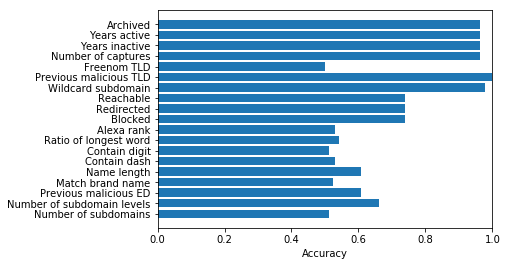


RandomForest: validate:
[(0.8363636363636363, 'Archived'),
 (0.8363636363636363, 'Years active'),
 (0.8363636363636363, 'Years inactive'),
 (0.8363636363636363, 'Number of captures'),
 (0.5, 'Freenom TLD'),
 (0.8343434343434344, 'Previous malicious TLD'),
 (0.5060606060606061, 'Wildcard subdomain'),
 (0.5404040404040404, 'Reachable'),
 (0.5404040404040404, 'Redirected'),
 (0.5404040404040404, 'Blocked'),
 (0.5404040404040404, 'Alexa rank'),
 (0.4909090909090909, 'Ratio of longest word'),
 (0.5202020202020202, 'Contain digit'),
 (0.5282828282828282, 'Contain dash'),
 (0.5878787878787879, 'Name length'),
 (0.4888888888888889, 'Match brand name'),
 (0.5545454545454546, 'Previous malicious ED'),
 (0.5747474747474748, 'Number of subdomain levels'),
 (0.4868686868686869, 'Number of subdomains')]


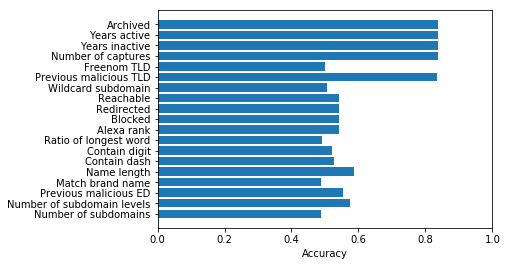


RandomForest: comp-deltaphish:
[(0.9172714078374455, 'Archived'),
 (0.8301886792452831, 'Years active'),
 (0.9172714078374455, 'Years inactive'),
 (1.0, 'Number of captures'),
 (1.0, 'Freenom TLD'),
 (1.0, 'Previous malicious TLD'),
 (0.11756168359941944, 'Wildcard subdomain'),
 (0.7010159651669086, 'Reachable'),
 (0.7010159651669086, 'Redirected'),
 (0.7010159651669086, 'Blocked'),
 (0.026124818577648767, 'Alexa rank'),
 (0.15529753265602322, 'Ratio of longest word'),
 (0.03773584905660377, 'Contain digit'),
 (0.10595065312046444, 'Contain dash'),
 (0.4412191582002903, 'Name length'),
 (0.3483309143686502, 'Match brand name'),
 (0.5007256894049347, 'Previous malicious ED'),
 (0.04934687953555878, 'Number of subdomain levels'),
 (0.027576197387518143, 'Number of subdomains')]


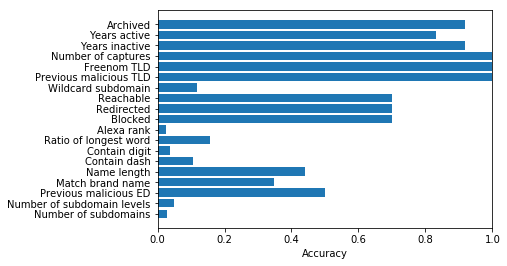


RandomForest: mal-future-apwg:
[(0.9426751592356688, 'Archived'),
 (0.9777070063694268, 'Years active'),
 (0.9426751592356688, 'Years inactive'),
 (0.0, 'Number of captures'),
 (0.0, 'Freenom TLD'),
 (0.4968152866242038, 'Previous malicious TLD'),
 (0.9267515923566879, 'Wildcard subdomain'),
 (0.12101910828025478, 'Reachable'),
 (0.12101910828025478, 'Redirected'),
 (0.12101910828025478, 'Blocked'),
 (0.9968152866242038, 'Alexa rank'),
 (0.8630573248407644, 'Ratio of longest word'),
 (0.9872611464968153, 'Contain digit'),
 (0.9585987261146497, 'Contain dash'),
 (0.7579617834394905, 'Name length'),
 (0.6464968152866242, 'Match brand name'),
 (0.5987261146496815, 'Previous malicious ED'),
 (0.9808917197452229, 'Number of subdomain levels'),
 (0.9490445859872612, 'Number of subdomains')]


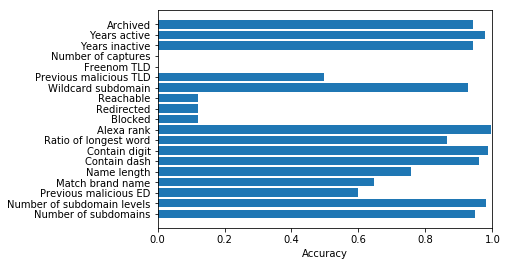


RandomForest: mal-phishlabs:
[(0.9194008559201141, 'Archived'),
 (0.9579172610556348, 'Years active'),
 (0.9194008559201141, 'Years inactive'),
 (0.0, 'Number of captures'),
 (0.0, 'Freenom TLD'),
 (0.006419400855920114, 'Previous malicious TLD'),
 (0.9350927246790299, 'Wildcard subdomain'),
 (0.8716119828815977, 'Reachable'),
 (0.8716119828815977, 'Redirected'),
 (0.8716119828815977, 'Blocked'),
 (0.996077032810271, 'Alexa rank'),
 (0.8377318116975749, 'Ratio of longest word'),
 (0.8020684736091298, 'Contain digit'),
 (0.4985734664764622, 'Contain dash'),
 (0.4111982881597718, 'Name length'),
 (0.6544222539229672, 'Match brand name'),
 (0.35021398002853066, 'Previous malicious ED'),
 (0.9629101283880172, 'Number of subdomain levels'),
 (0.9686162624821684, 'Number of subdomains')]


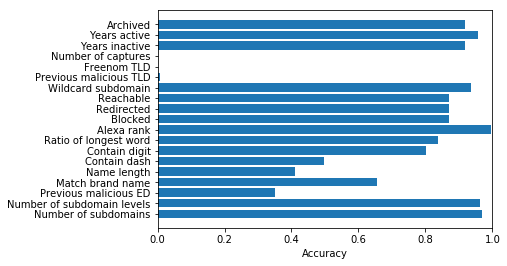


RandomForest: train_rest:
[(1.0, 'Archived'),
 (0.7457831325301205, 'Years active'),
 (1.0, 'Years inactive'),
 (1.0, 'Number of captures'),
 (1.0, 'Freenom TLD'),
 (1.0, 'Previous malicious TLD'),
 (1.0, 'Wildcard subdomain'),
 (1.0, 'Reachable'),
 (1.0, 'Redirected'),
 (1.0, 'Blocked'),
 (0.03313253012048193, 'Alexa rank'),
 (0.14518072289156628, 'Ratio of longest word'),
 (0.03855421686746988, 'Contain digit'),
 (0.12530120481927712, 'Contain dash'),
 (0.3825301204819277, 'Name length'),
 (0.3385542168674699, 'Match brand name'),
 (0.45481927710843373, 'Previous malicious ED'),
 (0.3325301204819277, 'Number of subdomain levels'),
 (0.14216867469879518, 'Number of subdomains')]


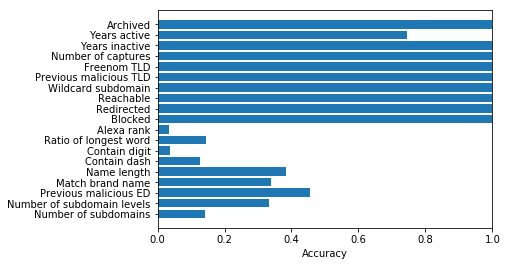


RandomForest: val_rest:
[(0.7241379310344828, 'Archived'),
 (0.5459770114942529, 'Years active'),
 (0.7241379310344828, 'Years inactive'),
 (1.0, 'Number of captures'),
 (1.0, 'Freenom TLD'),
 (0.9942528735632183, 'Previous malicious TLD'),
 (0.08620689655172414, 'Wildcard subdomain'),
 (0.7298850574712644, 'Reachable'),
 (0.7298850574712644, 'Redirected'),
 (0.7298850574712644, 'Blocked'),
 (0.07471264367816093, 'Alexa rank'),
 (0.1206896551724138, 'Ratio of longest word'),
 (0.07471264367816093, 'Contain digit'),
 (0.10344827586206896, 'Contain dash'),
 (0.367816091954023, 'Name length'),
 (0.3620689655172414, 'Match brand name'),
 (0.4425287356321839, 'Previous malicious ED'),
 (0.1896551724137931, 'Number of subdomain levels'),
 (0.06321839080459771, 'Number of subdomains')]


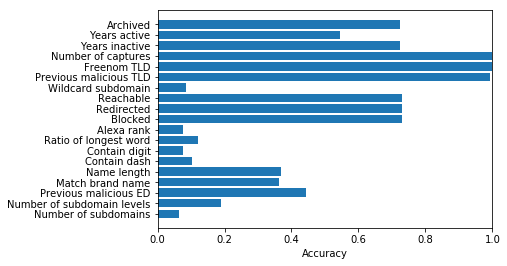

In [71]:
datasets = set([d['dataset'] for d in data_predict])
print(datasets)
#dataset_predict = ['comp-deltaphish','mal-future-apwg','mal-phishlabs', 'train_rest', 'val_rest']
dataset_predict = ['train', 'validate', 'comp-deltaphish','mal-future-apwg','mal-phishlabs', 'train_rest', 'val_rest']
#dataset_predict = ['train', 'validate']
clf = classifiers[3]
name = names[3]

print(feat_labels)

paper_feat_labels = feat_labels
paper_feat_labels = ['Archived', 'Years active', 'Years inactive', 'Number of captures', 'Freenom TLD', 'Previous malicious TLD', 'Wildcard subdomain', 'Reachable', 'Redirected', 'Blocked', 'Alexa rank', 'Ratio of longest word', 'Contain digit', 'Contain dash', 'Name length', 'Match brand name', 'Previous malicious ED', 'Number of subdomain levels', 'Number of subdomains']
for dataset in dataset_predict:
    acc_feat_list = []
    preprocess = True
    #for name, clf in zip(names, classifiers):
    for i, feat in enumerate(paper_feat_labels):
        clf.fit(Xtrain, ytrain)

        # get X and y for specific datasets
        if dataset == 'train_rest':
            Xpredict = Xtest
            ypredict = ytest
        elif dataset == 'val_rest':
            Xpredict = Xvaltestb
            ypredict = yvaltestb
        elif dataset == 'train':
            Xpredict = Xtrain
            ypredict = ytrain
            preprocess = False
        elif dataset == 'validate':
            Xpredict = Xvalb
            ypredict = yvalb
            preprocess = False
        else:
            Xpredict = np.array([d['feat'] for d in data_predict if d['dataset'] in dataset])
            ypredict = np.array([d['target'] for d in data_predict if d['dataset'] in dataset])

        if preprocess:
            # transform (handle nan and normalize)
            #Xpredict = imp.transform(Xpredict)
            Xpredict = np.where(np.isnan(Xpredict), -1, Xpredict)
            Xpredict = scaler.transform(Xpredict)

            # calibrate
            #Xpredict = applyIsoFunction(Xpredict, ypredict, iso_functions)

        # select single feat
        X = Xtrain[:,i].reshape(-1, 1)
        Xval = Xpredict[:,i].reshape(-1, 1)

        # evaluation criteria
        acc_feat_list.append(getAccuracy(X, Xval, ytrain, ypredict, clf, feat))

    print("%s: %s:" % (name, dataset))
    pprint(acc_feat_list)

    # show graph
    plotFeatures(acc_feat_list)
    print()

# Predict

In [58]:
datasets = set([d['dataset'] for d in data_predict])
print(datasets)
#dataset_predict = ['comp-deltaphish','mal-future-apwg','mal-phishlabs', 'train_rest', 'val_rest']
dataset_predict = ['mal-future-apwg','mal-phishlabs', 'comp-deltaphish','train_rest', 'val_rest']
compare_datasets=dict()
compare_datasets['acc'] = []
compare_datasets['err'] = []
compare_names = []
for dataset in dataset_predict:
    clf_datasets_acc = []
    clf_datasets_err = []
    clf_names = []
    for name, clf in zip(names, classifiers):
        clf.fit(Xtrain, ytrain)
        
        # get X and y for specific datasets
        if dataset == 'train_rest':
            Xpredict = Xtest
            ypredict = ytest
        elif dataset == 'val_rest':
            Xpredict = Xvaltestb
            ypredict = yvaltestb
        else:
            Xpredict = np.array([d['feat'] for d in data_predict if d['dataset'] in dataset])
            ypredict = np.array([d['target'] for d in data_predict if d['dataset'] in dataset])
        
        # transform (handle nan and normalize)
        #Xpredict = imp.transform(Xpredict)
        Xpredict = np.where(np.isnan(Xpredict), -1, Xpredict)
        Xpredict = scaler.transform(Xpredict)
        
        # calibrate
        Xpredict = applyIsoFunction(Xpredict, ypredict, iso_functions)
        
        # predict
        ypredict_pred = clf.predict(Xpredict)
        #tn, fp, fn, tp = confusion_matrix(ypredict, Xpredict_pred, labels=[-1,1]).ravel()
        
        # evaluation criteria
        acc = accuracy_score(ypredict, ypredict_pred)
        err = 1-acc
        #avg_acc = (tp+tn)/2
        
        # add avg_acc and corresponding name label
        clf_datasets_acc.append(acc)
        clf_datasets_err.append(err)
        clf_name = '-'.join([name, dataset])
        print(clf_name)
        clf_names.append(clf_name)
    
    # add dataset results for specific clf
    compare_datasets['acc'].append(clf_datasets_acc)
    compare_datasets['err'].append(clf_datasets_err)
    compare_names.append(clf_names)

{'unlabeled-apwg', 'comp-deltaphish', 'mal-apwg', 'mal-phishlabs', 'comp-phishlabs', 'mal-future-apwg'}
KNeighbors-mal-future-apwg
NeuralNetwork-mal-future-apwg
DecisionTree-mal-future-apwg
RandomForest-mal-future-apwg
GaussianNB-mal-future-apwg
Dummy-mal-future-apwg
KNeighbors-mal-phishlabs
NeuralNetwork-mal-phishlabs
DecisionTree-mal-phishlabs
RandomForest-mal-phishlabs
GaussianNB-mal-phishlabs
Dummy-mal-phishlabs
KNeighbors-comp-deltaphish
NeuralNetwork-comp-deltaphish
DecisionTree-comp-deltaphish
RandomForest-comp-deltaphish
GaussianNB-comp-deltaphish
Dummy-comp-deltaphish
KNeighbors-train_rest
NeuralNetwork-train_rest
DecisionTree-train_rest
RandomForest-train_rest
GaussianNB-train_rest
Dummy-train_rest
KNeighbors-val_rest
NeuralNetwork-val_rest
DecisionTree-val_rest
RandomForest-val_rest
GaussianNB-val_rest
Dummy-val_rest


In [59]:
# with calibration
pprint(compare_datasets['acc'])

[[0.9554140127388535,
  0.9554140127388535,
  0.9585987261146497,
  0.9490445859872612,
  0.9203821656050956,
  0.5222929936305732],
 [0.9315263908701854,
  0.9087018544935807,
  0.9197574893009985,
  0.8801711840228246,
  0.8937232524964337,
  0.5035663338088445],
 [0.6981132075471698,
  0.8896952104499274,
  0.9172714078374455,
  0.9172714078374455,
  0.13352685050798258,
  0.4934687953555878],
 [1.0, 1.0, 1.0, 1.0, 1.0, 0.4939759036144578],
 [0.6724137931034483,
  0.7183908045977011,
  0.7241379310344828,
  0.7298850574712644,
  0.1724137931034483,
  0.5287356321839081]]


In [127]:
# without calibration
pprint(compare_datasets['acc'])

[[0.9299363057324841,
  0.9426751592356688,
  0.9585987261146497,
  0.9490445859872612,
  0.9171974522292994,
  0.5222929936305732],
 [0.9022824536376605,
  0.8758915834522111,
  0.9197574893009985,
  0.8801711840228246,
  0.8926533523537803,
  0.5035663338088445],
 [0.6995645863570392,
  0.8940493468795355,
  0.9172714078374455,
  0.9172714078374455,
  0.1378809869375907,
  0.4934687953555878],
 [1.0, 1.0, 1.0, 1.0, 1.0, 0.4939759036144578],
 [0.6896551724137931,
  0.7241379310344828,
  0.7241379310344828,
  0.7298850574712644,
  0.1781609195402299,
  0.5287356321839081]]


#### Balanced Accuracy

In [60]:
#compare_datasets_temp = compare_datasets[:3]
balanced_acc = []

for i in range(6): # 5 algorithms
    x = ((compare_datasets['acc'][0][i] + compare_datasets['acc'][1][i])/2 + compare_datasets['acc'][2][i])/2
    balanced_acc.append(x)
    #balanced_acc.append(((compare_datasets[0][i] + compare_datasets[1][i])/2 + compare_datasets[2][i])/2)

pprint(balanced_acc)

[0.8207917046758446,
 0.9108765720330723,
 0.9282247577726348,
 0.9159396464212441,
 0.5202897797793736,
 0.5031992295376484]


# Decision Tree rules

In [55]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    #print("def tree({}):".format(", ".join(feature_names)))
    print("def tree(%s):" % (", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("%sif %s <= %s:" % (indent, name, str(threshold)))
            recurse(tree_.children_left[node], depth + 1)
            #print("{}else:  # if {} > {}".format(indent, name, threshold))
            print("%selse:  # if %s > %s" % (indent, name, str(threshold)))
            recurse(tree_.children_right[node], depth + 1)
        else:
            #print("{}return {}".format(indent, tree_.value[node]))
            print("%sreturn %s" % (indent, tree_.value[node]))
            #pass

    recurse(0, 1)

In [56]:
clf = classifiers[2]
clf.fit(Xtrain, ytrain)
tree_to_code(clf, feat_labels)

def tree(archived, years_active, years_inactive, num_captures, freenom_tld, prev_mal_tld, wildcard_subdomain, reachable, redirected, blocked, alexa_rank, ratio_longest_word, contain_digit, contain_dash, name_len, brandname_partialratio, prev_mal_domain_ed, sub_levels, num_sub):
  if archived <= -0.07563164830207825:
    return [[1888.    0.]]
  else:  # if archived > -0.07563164830207825
    if prev_mal_tld <= 0.0:
      return [[   0. 2042.]]
    else:  # if prev_mal_tld > 0.0
      return [[154.   0.]]


In [49]:
clf = classifiers[2]
clf.fit(Xtrain, ytrain)
tree_to_code(classifiers[2], feat_labels)

def tree(archived, years_active, years_inactive, num_captures, freenom_tld, wildcard_subdomain, reachable, redirected, blocked, alexa_rank, ratio_longest_word, contain_digit, contain_dash, name_len, brandname_partialratio, sub_levels, num_sub):
  if years_active <= -0.24913495779037476:
    return [[1888.    0.]]
  else:  # if years_active > -0.24913495779037476
    if wildcard_subdomain <= -0.046082139015197754:
      return [[116.   0.]]
    else:  # if wildcard_subdomain > -0.046082139015197754
      if reachable <= -0.6112680435180664:
        return [[2. 0.]]
      else:  # if reachable > -0.6112680435180664
        if brandname_partialratio <= 0.0754450112581253:
          return [[  7. 114.]]
        else:  # if brandname_partialratio > 0.0754450112581253
          return [[  29. 1928.]]


# Friedman test and Nemenyi CD

In [30]:
# compare samples
#stat, p = friedmanchisquare(compare_datasets['acc'][0], compare_datasets['acc'][1], compare_datasets['acc'][2], compare_datasets['acc'][3], compare_datasets['acc'][4])
stat, p = friedmanchisquare(compare_datasets['acc'][0], compare_datasets['acc'][1], compare_datasets['acc'][2])

print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=7.600, p=0.022
Different distributions (reject H0)


In [250]:
from numpy.random import seed
from numpy.random import randn
# seed the random number generator
seed(1)
# generate three independent samples
data1 = 5 * randn(100) + 50
data2 = 5 * randn(100) + 50
data3 = 5 * randn(100) + 52
# compare samples
stat, p = friedmanchisquare(data1, data2, data3)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=9.360, p=0.009
Different distributions (reject H0)


In [35]:
ranks = []
for i, comp in enumerate(compare_datasets['err']):
    rank = rankdata(comp)
    ranks.append(rank)
    #if i > 2:
    #    break
print(ranks)
avranks = np.mean(ranks, axis=0)
print(avranks)

[array([4., 2., 3., 1., 5.]), array([2., 2., 2., 4., 5.]), array([2., 3., 1., 4., 5.]), array([2., 2., 4., 2., 5.]), array([3., 2., 4., 1., 5.])]
[2.6 2.2 2.8 2.4 5. ]


5


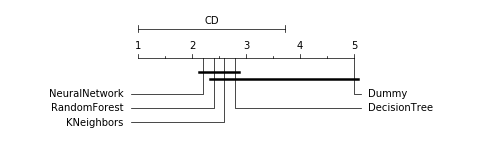

In [36]:
#names = ["first", "third", "second", "fourth" ]
#avranks =  [1.9, 3.2, 2.8, 3.3 ]
num_datasets = len(dataset_predict)
print(num_datasets)
cd = compute_CD(avranks, num_datasets)
graph_ranks(avranks, names, cd=cd, width=6, textspace=1.5)
plt.show()

# Model persistence

In [47]:
from joblib import dump, load
modelname = 'apwg'
filename = './model/'+modelname+'_scaler.joblib'
dump(scaler, filename)

['./model/apwg_scaler.joblib']

In [48]:
# filename = './model/'+modelname+'_imputer.joblib'
# dump(imp, filename)

In [49]:
clf = classifiers[3]
clf.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [50]:
#from joblib import dump, load
filename = './model/'+modelname+'_model.joblib'
dump(clf, filename)
#pickle.dump(clf, 'mlp.joblib') 

['./model/apwg_model.joblib']